In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random

from argparse import ArgumentParser
import datetime

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.backends.cudnn as cudnn


from pytvision.datasets.factory  import FactoryDataset 
from pytvision.datasets.datasets import Dataset 
from pytvision.datasets.fersynthetic  import SyntheticFaceDataset
from pytvision.transforms import transforms as mtrans
from pytvision import visualization as view

sys.path.append('../')
# from torchlib.datasets.factory  import FactoryDataset 
# from torchlib.datasets.datasets import Dataset 
# from torchlib.datasets.fersynthetic  import SyntheticFaceDataset
from torchlib.neuralnet import NeuralNetClassifier
from misc import get_transforms_det

from sklearn import metrics

/home/viisar/tir/projeto/programs/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
pathname = os.path.expanduser( '~/.datasets' )
projectnet='../out/baselinenetruns'
no_cuda=False
seed=1
gpu=1
batch_size=10
workers=0
num_input_channels=3

print(pathname)
print(projectnet)


/root/.datasets
../out/baselinenetruns


In [3]:
!ls ../out/baselinenetruns/

baseline_alexnet_cross_adam_ferp_weights_000
baseline_cvgg13_cross_adam_ferp_weights_000
baseline_dexpression_cross_adam_ferp_weights_000
baseline_fmp_cross_adam_ferp_weights_000
baseline_preactresnet18_cross_adam_ferp_weights_000
baseline_resnet18_cross_adam_ferp_weights_000


In [4]:
name = 'baseline_dexpression_cross_adam_ferp_weights_000'
project = os.path.join(projectnet, name)
model = 'model_best.pth.tar' #'chk000025.pth.tar', model_best
pathmodels = os.path.join(project,'models',model)

print(project)
print(pathmodels)

../out/baselinenetruns/baseline_dexpression_cross_adam_ferp_weights_000
../out/baselinenetruns/baseline_dexpression_cross_adam_ferp_weights_000/models/model_best.pth.tar


## Load model

In [5]:
# neuralnet
network = NeuralNetClassifier(
    patchproject=project,
    nameproject=name,
    no_cuda=no_cuda,
    seed=seed,
    gpu=gpu
    )

cudnn.benchmark = True

# load model
if network.load( pathmodels ) is not True:
    assert(False)

=> loading checkpoint '../out/baselinenetruns/baseline_dexpression_cross_adam_ferp_weights_000/models/model_best.pth.tar'
=> loaded checkpoint for dexpression arch!


In [43]:
name_dataset=FactoryDataset.affect
subset=FactoryDataset.validation

nactores=10
kfold=0
idenselect = [] #np.arange(nactores) + kfold*nactores
breal=True


data = Dataset(
    data=FactoryDataset.factory(
        pathname=pathname, 
        name=name_dataset, 
        subset=subset, 
        #idenselect=idenselect,
        download=True ),
    num_channels=num_input_channels,
    transform=get_transforms_det(network.size_input)
    )

# data = SyntheticFaceDataset(
#     data=FactoryDataset.factory(
#         pathname=pathname, 
#         name=name_dataset, 
#         subset=subset, 
#         #idenselect=idenselect,
#         download=True 
#         ),
#     pathnameback='~/.datasets/coco', 
#     generate='image_and_label',
#     ext='jpg',
#     count=2000,
#     num_channels=network.num_input_channels,
#     iluminate=True, angle=45, translation=0.3, warp=0.2, factor=0.2,
#     #iluminate=True, angle=45, translation=0.1, warp=0.0, factor=0.0,
#     transform_image=get_transforms_det( network.size_input )
#     )


dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=workers )

print('Data loader ')
print(len(dataloader))
print(len(data))

Data loader 
58
580


In [44]:
Yhat, Y = network.test( dataloader )
df = pd.DataFrame( np.concatenate((Yhat, Y), axis=1) )
df.to_csv( os.path.join(project , '{}_{}_{}_dp.csv'.format(subset,name,name_dataset)), index=False, encoding='utf-8')       

print('dir: {}'.format(project))
print('DONE!!!')

100%|██████████| 58/58 [00:00<00:00, 83.59it/s]

dir: ../out/baselinenetruns/baseline_cvgg13_cross_adam_ferp_weights_000
DONE!!!


In [45]:
df = pd.read_csv( os.path.join(project , '{}_{}_{}_dp.csv'.format(subset, name, name_dataset))  )
df.head()

,0,1,2,3,4,5,6,7,8
0,2.976395e-04,9.991634e-01,4.521675e-06,9.039359e-05,4.439298e-04,1.236433e-07,4.374791e-08,1.604773e-08,5.0
1,4.987014e-09,1.000000e+00,4.921211e-09,1.262770e-14,1.083662e-14,2.131488e-23,2.307422e-17,2.137197e-22,1.0
2,9.999895e-01,1.471812e-08,1.193038e-06,9.292635e-06,2.759569e-08,1.661880e-17,2.818471e-15,4.663679e-13,0.0
3,9.656357e-01,4.566129e-08,8.904398e-07,3.427742e-02,8.585987e-05,1.223359e-10,1.911448e-10,2.048259e-11,3.0
4,3.641985e-07,6.459234e-11,9.999996e-01,1.186124e-09,2.486867e-11,5.986171e-21,2.083649e-08,1.070712e-17,2.0


In [46]:
result = df.as_matrix()
yhat = np.argmax( result[:,:-1], axis=1 )
y = result[:,-1]

acc = metrics.accuracy_score(y, yhat)
precision = metrics.precision_score(y, yhat, average='macro')
recall = metrics.recall_score(y, yhat, average='macro')
f1_score = 2*precision*recall/(precision+recall)

# print('Accuracy : %f' % acc)
# print('Precision : %f' % precision)
# print('Recall : %f' % recall)
# print('F1 score : %f' % f1_score)
# print("")
print('|Acc\t|Prec\t|Rec\t|F1\t|')
print( '|{:0.3f}\t|{:0.3f}\t|{:0.3f}\t|{:0.3f}\t|'.format(acc,precision,recall,f1_score).replace('.',',')  )

print()
print( '{:0.3f}\n{:0.3f}\n{:0.3f}\n{:0.3f}'.format(acc*100,precision*100,recall*100,f1_score*100).replace('.',',')  )

|Acc	|Prec	|Rec	|F1	|
|0,421	|0,512	|0,384	|0,439	|

42,069
51,238
38,412
43,908


In [47]:
metric = metrics.classification_report(y, yhat)
print(metric)

              precision    recall  f1-score   support

         0.0       0.30      1.00      0.46        90
         1.0       0.63      1.00      0.77        89
         2.0       0.84      0.76      0.80        49
         3.0       0.37      0.13      0.19        85
         4.0       0.16      0.09      0.12        89
         5.0       0.80      0.09      0.16        92
         6.0       1.00      0.01      0.02        86
         7.0       0.00      0.00      0.00         0

   micro avg       0.42      0.42      0.42       580
   macro avg       0.51      0.38      0.31       580
weighted avg       0.57      0.42      0.33       580



In [11]:
mc = metrics.confusion_matrix(y, yhat)
print(mc)

[[935  26  14  76  29   1   0   2]
 [ 37 812  18  17   8   0   0   0]
 [ 20   7 356   3   3   0   5   0]
 [ 86  19   2 256  13   1   3   2]
 [ 15   6   5   6 234   2   1   0]
 [  1   0   2   0   5   8   0   0]
 [  7   2  23  11   2   0  41   0]
 [  3   2   1   2   4   0   0   3]]


Normalized confusion matrix


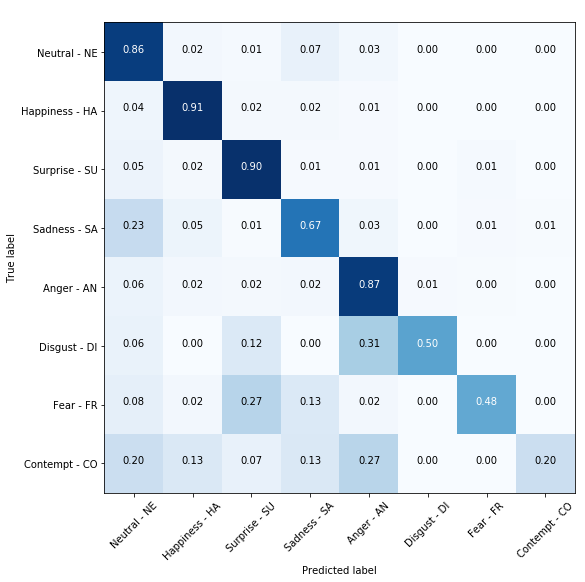

In [12]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plt.figure( figsize=(8,8))
plot_confusion_matrix(mc, classes=data.data.classes, title=' ')
plt.show()